In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

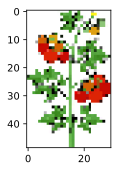

In [3]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from PIL import Image
import torchvision.utils as vutils

d2l.set_figsize()
content_img = Image.open('/home/zxt/Python_area/for_wu_ding_minecraft_modules/datas/1_origin_data/pixel_tomatoes.png')
content_img = content_img.convert('RGB')
d2l.plt.imshow(content_img)

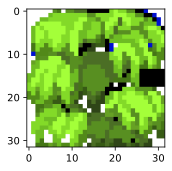

In [4]:
style_img = Image.open('/home/zxt/Python_area/for_wu_ding_minecraft_modules/datas/1_origin_data/bamboo_leaf.jpg')
style_img = style_img.convert('RGB')
d2l.plt.imshow(style_img)

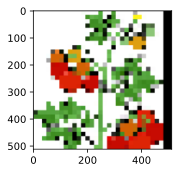

In [5]:
# 函数定义, 将32*32的风格图像放大到512*512, 原图中的每个像素向右下扩散16*16个像素
from click import style


def super_resolution_to_512(img):
    img = img.convert('RGB')
    img_torch = torchvision.transforms.ToTensor()(img)
    # print(img_torch.size())
    img_512 = torch.zeros((3, 512, 512))
    # print(img_512.size())
    for i in range(0,3):
        for j in range(0, img_torch.size()[1]):
            for k in range(0, img_torch.size()[2]):
                img_512[i, 16*j:16*(j+1), 16*k:16*(k+1)] = img_torch[i, j, k]
    # print(img_512.size())
    return img_512


content_img_512 = super_resolution_to_512(content_img)
d2l.plt.imshow(content_img_512.permute(1, 2, 0))


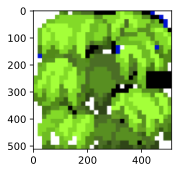

In [6]:
style_img_512 = super_resolution_to_512(style_img)
d2l.plt.imshow(style_img_512.permute(1, 2, 0))

In [7]:
from matplotlib import transforms


rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape=512):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(image_shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
        ]
    )

    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [8]:
pretrained_net = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1)

In [9]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [25]

In [13]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])
# for i in range(max(content_layers + style_layers) + 1):
#     print(pretrained_net.features[i])
    

In [10]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [11]:
def get_contents(image_shape, device):
    content_X = super_resolution_to_512(content_img)
    content_X = torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)(content_X)
    content_X = content_X.unsqueeze(0).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = super_resolution_to_512(style_img)
    style_X = torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)(style_X)
    style_X = style_X.unsqueeze(0).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

# a,b = get_styles((512,512), 'cuda')

# vutils.save_image(a, 'test.png')


In [12]:
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

In [13]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [14]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [15]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [torch.square(gram(Y_hat) - Y_gram).mean() * style_weight
                for Y_hat, Y_gram in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [16]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [17]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

In [18]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs],legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        # print(f"epoch{epoch}")
        
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        # print(f"contents_l:{contents_l}\n")
        l.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)), float(sum(styles_l)), float(tv_l)])
    return X

In [19]:
device = d2l.try_gpu()
print(device)

cuda:0


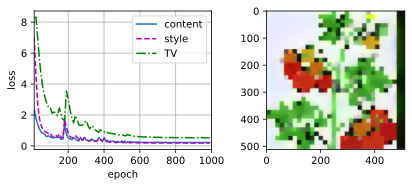

: 

In [20]:
device, image_shape = 'cuda:1', (512,512)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50)

In [1]:
# 将512*512的图像X下采样到32*32, 并保存
def downsample_to_32(img):
    img = img.permute(1, 2, 0)
    print(img.size())
    img_32 = torch.zeros((32, 32, 3))
    for i in range(0, 32):
        for j in range(0, 32):
            img_32[i, j, :] = img[16*i, 16*j, :]
    return img_32


img = output.requires_grad_(False)
vutils.save_image(img, '/home/zxt/Python_area/for_wu_ding_minecraft_modules/datas/3_style_data/generated_tomatoes__van_512.png')
print(img.size())
# output_32 = downsample_to_32(img)
# print(type(output_32))
# print(output_32.size())
# # 修改张量out_put_32的维度, 使其满足vutils.save_image的要求
# output_32 = output_32.permute(2, 0, 1)
# print(output_32.size())
# vutils.save_image(output_32, '/home/zxt/Python_area/for_wu_ding_minecraft_modules/datas/3_style_data/generated_tomatoes_van_32.png')

NameError: name 'output' is not defined